In [5]:
import yfinance as yf
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

In [6]:
start = pd.to_datetime('2010-08-02')
end = pd.to_datetime('2018-08-02')
stock = ['GOOG']
data = yf.download(stock, start = start, end = end)
dates = data.index
columns = data.columns
data.index.name = "Date" #add date as column
data.reset_index(inplace = True)
data.index.name = "timeT" #add time as column
data.reset_index(inplace = True)
print(data.head())

print(len(data))
data_train = data.iloc[0:1601,] ##train set needs to be one bigger to be able to lag one..
data_test = data.iloc[1601:2001,]
print(len(data_train))
print(len(data_test))

[*********************100%***********************]  1 of 1 completed
   timeT       Date       Open       High        Low      Close  Adj Close   
0      0 2010-08-02  12.179100  12.285949  12.128041  12.214467  12.214467  \
1      1 2010-08-03  12.216709  12.265526  12.123558  12.200021  12.200021   
2      2 2010-08-04  12.258552  12.627668  12.230407  12.610732  12.610732   
3      3 2010-08-05  12.600022  12.667519  12.541990  12.655066  12.655066   
4      4 2010-08-06  12.587818  12.596286  12.354941  12.458801  12.458801   

      Volume  
0   74626675  
1   72362219  
2  153071607  
3   97178890  
4  133277692  
2015
1601
400


<Axes: >

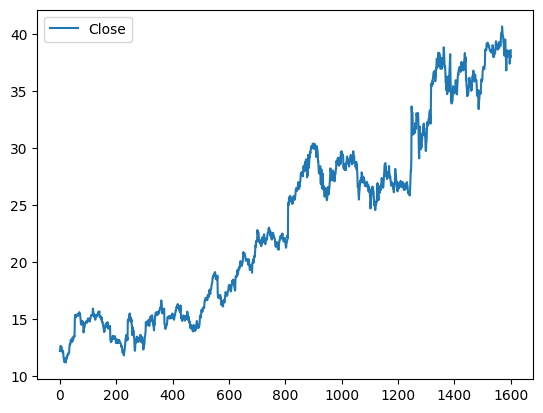

In [7]:
seaborn.lineplot(data_train.loc[:,["Close"]]) #plot the value of close

In [8]:
##first let us fit log(Y) = t + c, with Y value of the stock and t the time and c some constant
PF = np.polyfit(data_train.loc[:,"timeT"], np.log(data_train.loc[:,"Close"]), 1)
PF

array([7.63891161e-04, 2.48935997e+00])

In [9]:
#use the estimates to calculate the curve
removeExponent = data_train.loc[:,["Close", "timeT"]]
removeExponent["Estimate"] = np.exp(PF[0]*removeExponent["timeT"]+PF[1])
removeExponent["NoExp"] = removeExponent["Close"]/removeExponent["Estimate"] ##devide by trend

<Axes: ylabel='NoExp'>

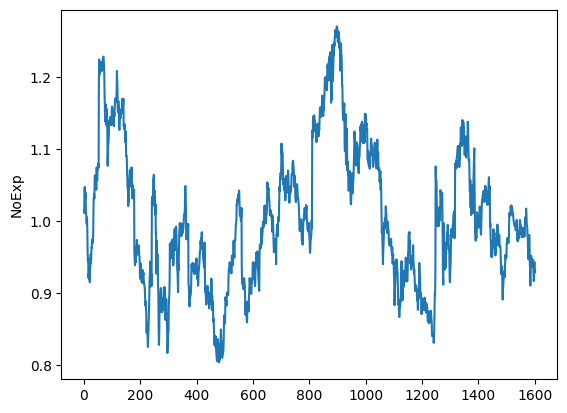

In [10]:
# plot the line with the trend removed
seaborn.lineplot((removeExponent.loc[:,"NoExp"]))

<Axes: >

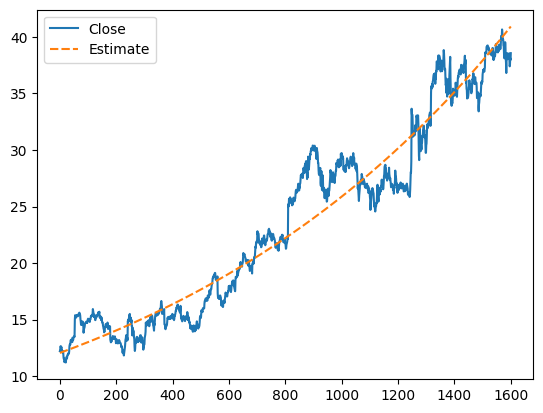

In [11]:
seaborn.lineplot(removeExponent.loc[:,["Close","Estimate"]])

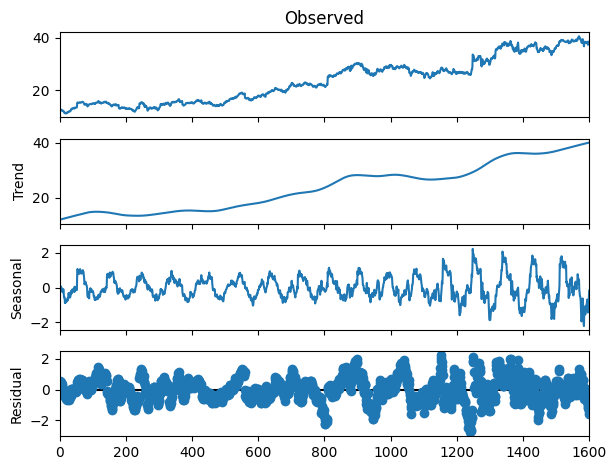

In [12]:
##something we did not full understand. Something with seasonality, however above doesnt nescessary show seasonality

from statsmodels.tsa.seasonal import STL

closeFrame = removeExponent.loc[:,"Close"]
closeFrame.index = [i for i in range(closeFrame.shape[0])]

res = STL(np.array(closeFrame), period=90).fit()
fig = res.plot()

In [43]:
#needed for ARMA model
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller


plot_pacf(dfTrySomething['NoExp'].dropna());
plot_acf(dfTrySomething['NoExp'].dropna());

ad_fuller_result = adfuller(dfTrySomething['NoExp'].dropna())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

NameError: name 'dfTrySomething' is not defined

In [13]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
import numpy as np

def series_to_supervised(data, n_in=1, n_out=1, dropnan = True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

data_clean = data[['Close', 'Open', 'High', 'Low', 'Volume']]
reframed = series_to_supervised(data_clean.values)
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)

print(reframed)

# set desired prediction window
n = 5

# Calculate the split index for 80/20 split, considering multiples of 5
split_index = int(len(reframed) * 0.8) // n * n
end_index = reframed.shape[0] // n * n

# split into train and test sets
values = reframed.values
train = values[:split_index, :]
test = values[split_index:end_index:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(X_train, y_train, X_test, y_test)


      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)    var5(t-1)    var1(t)
1     12.214467  12.179100  12.285949  12.128041   74626675.0  12.200021
2     12.200021  12.216709  12.265526  12.123558   72362219.0  12.610732
3     12.610732  12.258552  12.627668  12.230407  153071607.0  12.655066
4     12.655066  12.600022  12.667519  12.541990   97178890.0  12.458801
5     12.458801  12.587818  12.596286  12.354941  133277692.0  12.586572
...         ...        ...        ...        ...          ...        ...
2010  63.185001  61.956501  63.292999  61.956501   42556000.0  63.416500
2011  63.416500  62.549999  63.488548  62.451000   48112000.0  61.924999
2012  61.924999  63.549999  63.694500  61.549999   42612000.0  60.987000
2013  60.987000  61.400501  61.745800  60.573502   36998000.0  60.862999
2014  60.862999  61.000500  61.379398  60.279999   32894000.0  61.000500

[2014 rows x 6 columns]
(1610, 1, 5) (1610,) (400, 1, 5) (400,)
[[[1.22144670e+01 1.21791000e+01 1.22859488e+01 1.21280413e

In [ ]:
import matplotlib.pyplot as plt

# define parameters
verbose, epochs, batch_size = 2, 50, 72
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps, n_features)))  # Add LSTM layer with 50 units
model.add(RepeatVector(n_outputs))  # Repeat the output sequence
model.add(Dense(1))  # Add a dense layer with 1 unit
model.compile(loss='mae', optimizer='adam')  # Compile the model with mean absolute error loss and Adam optimizer
# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=verbose)  # Train the model



Epoch 1/50
23/23 - 2s - loss: 23.4140 - val_loss: 48.8897 - 2s/epoch - 68ms/step
Epoch 2/50
23/23 - 0s - loss: 23.2509 - val_loss: 48.7266 - 50ms/epoch - 2ms/step
Epoch 3/50
23/23 - 0s - loss: 23.0877 - val_loss: 48.5634 - 52ms/epoch - 2ms/step
Epoch 4/50
23/23 - 0s - loss: 22.9246 - val_loss: 48.4003 - 62ms/epoch - 3ms/step
Epoch 5/50
23/23 - 0s - loss: 22.7614 - val_loss: 48.2372 - 58ms/epoch - 3ms/step
Epoch 6/50
23/23 - 0s - loss: 22.5983 - val_loss: 48.0740 - 53ms/epoch - 2ms/step
Epoch 7/50
23/23 - 0s - loss: 22.4352 - val_loss: 47.9109 - 54ms/epoch - 2ms/step
Epoch 8/50
23/23 - 0s - loss: 22.2721 - val_loss: 47.7478 - 53ms/epoch - 2ms/step
Epoch 9/50
23/23 - 0s - loss: 22.1089 - val_loss: 47.5846 - 55ms/epoch - 2ms/step
Epoch 10/50
23/23 - 0s - loss: 21.9458 - val_loss: 47.4215 - 58ms/epoch - 3ms/step
Epoch 11/50
23/23 - 0s - loss: 21.7827 - val_loss: 47.2584 - 65ms/epoch - 3ms/step
Epoch 12/50
23/23 - 0s - loss: 21.6195 - val_loss: 47.0952 - 57ms/epoch - 2ms/step
Epoch 13/50
23

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(X_test)
print(yhat.shape)


13/13 [==============================] - 0s 1ms/step
(405, 1, 1)


In [91]:
### Otto
n_input = 1
n_output = 1
n_windows = 16
size_train = np.size(train) #1600
r_neuron = 120
print(size_train)



1300


In [92]:
cutOff = 1300 
delay = 1
data = np.array(removeExponent.NoExp)

test = data[cutOff:]
train = data[:cutOff]

size_train = len(train)
size_test = len(test)

x_train = train[:size_train - 1]
x_train = np.reshape(x_train, (len(x_train), delay, 1))
y_train = train[1:size_train]

x_test = test[:size_test - 1]
x_test = np.reshape(x_test, (len(x_test), delay, 1))
y_test = test[1:size_test]

# time_steps = 1
# dat = train
# Y_ind = np.arange(time_steps, len(dat), time_steps)
# Y = dat[Y_ind]
# rows_x = len(Y)
# X = dat[range(time_steps*rows_x)]
# X = np.reshape(X, (rows_x, time_steps, 1))
# print(X)


In [99]:
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.SimpleRNN(120, input_shape = (1,1), activation="relu"))
model.add(layers.Dense(1, activation = "relu"))




# model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                #    activation=['tanh', 'tanh'])
# model.fit(x_data, y_data, epochs=20, batch_size=1, verbose=2)

model.summary()

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=100, epochs= 20)




Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_26 (SimpleRNN)   (None, 120)               14640     
                                                                 
 dense_26 (Dense)            (None, 1)                 121       
                                                                 
Total params: 14761 (57.66 KB)
Trainable params: 14761 (57.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
13/13 [==============================] - 1s 929us/step - loss: 0.7094 - accuracy: 0.0000e+00
Epoch 2/20
13/13 [==============================] - 0s 848us/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0879 - accuracy: 0.0000e+00
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0126 - accuracy: 0.0000e+00
E

In [100]:
predictTrain = model.predict(x_train)
predictTest = model.predict(x_test)
print(len(x_train), len(x_test))
print(len(data))




10/10 [==============================] - 0s 500us/step
1299 300
1601


In [108]:
modelResults = pd.DataFrame();
modelResults["realValues"] = np.append(y_train, y_test)
modelResults["estimatedValues"] = np.append(predictTrain, predictTest)
modelResults["estimatedValuesTransposedBack"] = modelResults["estimatedValues"] * removeExponent["Estimate"]
modelResults["originalValues"] = removeExponent["Close"]

print(modelResults)

      realValues  estimatedValues  estimatedValuesTransposedBack   
0       1.011378         1.012245                      12.201150  \
1       1.044628         1.010911                      12.194383   
2       1.047500         1.033407                      12.475280   
3       1.030467         1.035351                      12.508294   
4       1.040240         1.023826                      12.378514   
...          ...              ...                            ...   
1594    0.916708         0.955730                      38.928336   
1595    0.919168         0.946857                      38.596408   
1596    0.933176         0.948521                      38.693797   
1597    0.928293         0.957999                      39.110302   
1598    0.942346         0.954696                      39.005220   

      originalValues  
0          12.214467  
1          12.200021  
2          12.610732  
3          12.655066  
4          12.458801  
...              ...  
1594       38.542000  

<Axes: >

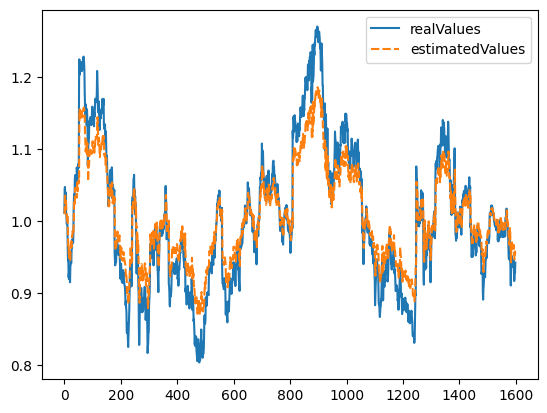

In [105]:
seaborn.lineplot(modelResults.loc[:,["realValues", "estimatedValues"]])

<Axes: >

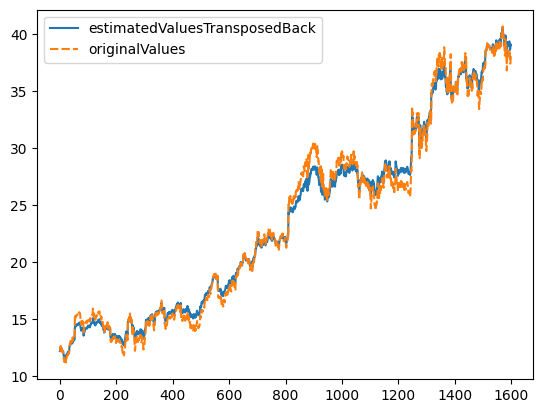

In [109]:
seaborn.lineplot(modelResults.loc[:,["estimatedValuesTransposedBack", "originalValues"]])

Epoch 1/20
1299/1299 - 1s - loss: 0.4846 - accuracy: 0.0000e+00 - 698ms/epoch - 538us/step
Epoch 2/20
1299/1299 - 0s - loss: 0.1631 - accuracy: 0.0000e+00 - 420ms/epoch - 324us/step
Epoch 3/20
1299/1299 - 0s - loss: 0.1597 - accuracy: 0.0000e+00 - 426ms/epoch - 328us/step
Epoch 4/20
1299/1299 - 0s - loss: 0.1594 - accuracy: 0.0000e+00 - 424ms/epoch - 326us/step
Epoch 5/20
1299/1299 - 0s - loss: 0.1586 - accuracy: 0.0000e+00 - 425ms/epoch - 327us/step
Epoch 6/20
1299/1299 - 0s - loss: 0.1580 - accuracy: 0.0000e+00 - 415ms/epoch - 319us/step
Epoch 7/20
1299/1299 - 0s - loss: 0.1573 - accuracy: 0.0000e+00 - 406ms/epoch - 313us/step
Epoch 8/20
1299/1299 - 0s - loss: 0.1569 - accuracy: 0.0000e+00 - 436ms/epoch - 336us/step
Epoch 9/20
1299/1299 - 0s - loss: 0.1570 - accuracy: 0.0000e+00 - 460ms/epoch - 354us/step
Epoch 10/20
1299/1299 - 0s - loss: 0.1566 - accuracy: 0.0000e+00 - 447ms/epoch - 344us/step
Epoch 11/20
1299/1299 - 0s - loss: 0.1563 - accuracy: 0.0000e+00 - 430ms/epoch - 331us/st

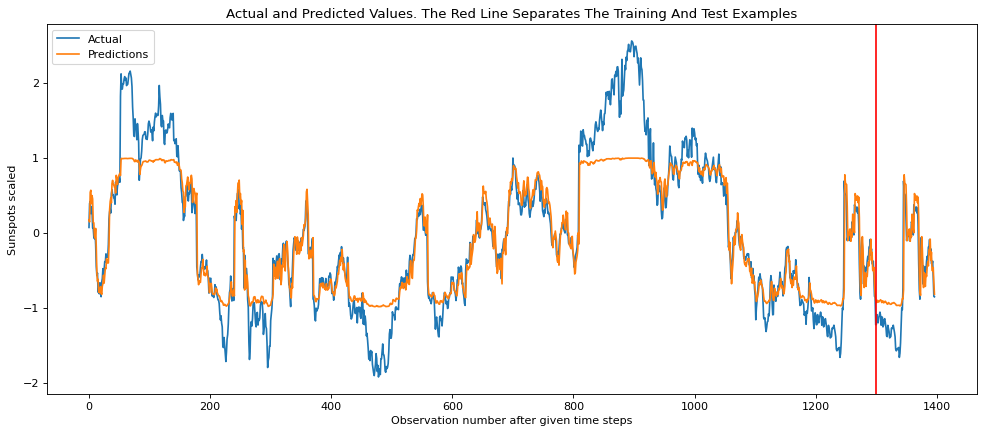

In [62]:
from pandas import read_csv
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# Parameter split_percent defines the ratio of training examples
def get_train_test(url, split_percent=0.8):
    df = read_csv(url, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data
 
# Prepare the input X and target Y
def get_XY(dat, time_steps):
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    rows_x = len(Y)
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])
    return model
 
def print_error(trainY, testY, train_predict, test_predict):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    
 
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
 
sunspots_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv'
time_steps = 1
train = (train - np.mean(train))/np.std(train)
train_data = train[0:1200]
test_data = train[1201:1600]
trainX, trainY = get_XY(train, time_steps)
testX, testY = get_XY(test_data, time_steps)


# Create model and train
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(time_steps,1), 
                   activation=['tanh', 'tanh'])
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
 
# make predictions
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
 
# Print error
print_error(trainY, testY, train_predict, test_predict)
 
#Plot result
plot_result(trainY, testY, train_predict, test_predict)

In [63]:
print(trainX)
print(trainY)
print(len(train))

[[[ 0.09034692]]

 [[ 0.07143482]]

 [[ 0.39040822]]

 ...

 [[-0.37753029]]

 [[-0.58894029]]

 [[-0.8480157 ]]]
[ 0.07143482  0.39040822  0.41795966 ... -0.58894029 -0.8480157
 -0.8535417 ]
1300
